In [1]:
import hist

from lmfit import Parameters
from lmfit.models import PolynomialModel, GaussianModel, ExponentialModel, PowerLawModel, RectangleModel

import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd


def load_mca_file(mcafile, rebin=1):

    df = pd.read_csv(mcafile, encoding='cp1252')
    
    counts = []
    save_data = False

    for row in df.to_numpy():
        if row[0] == '<<END>>':
            save_data = False
        if save_data:
            counts.append(float(row[0]))
        if row[0] == '<<DATA>>':
            save_data = True

    counts = np.array(counts, dtype=int)    
    bins = np.arange(8193)
    
    histogram = hist.Hist(
        hist.axis.Variable(bins, name="Ch", label="Channels"),
        storage=hist.storage.Weight(),
    )

    bin_centers = histogram.axes[0].centers

    for center, count in zip(bin_centers, counts):
        histogram.fill(np.full(count, center))

    return histogram[::hist.rebin(rebin)]

Text(0, 0.5, 'Conteggi / 8 Canali')

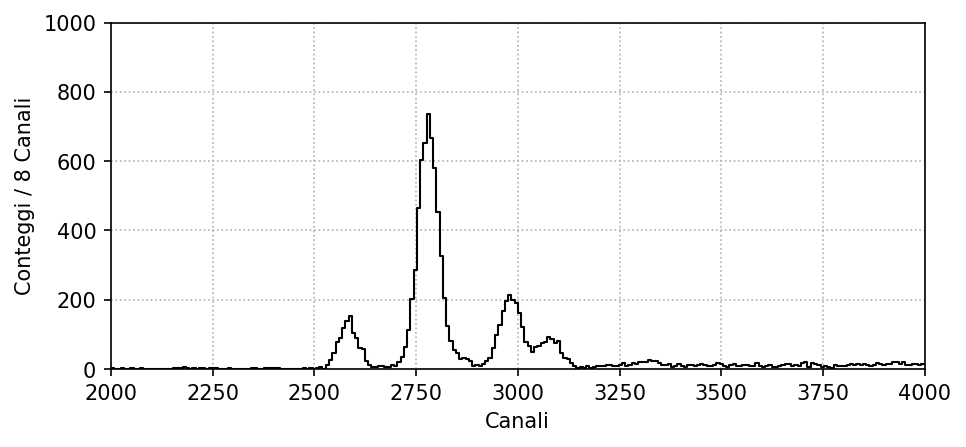

In [60]:
rebin = 8
histogram = load_mca_file('2024_11_04_V20_I300_T100_CuNiZn.mca', rebin=rebin)

fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")
# ax.set_yscale('log')

centers = histogram.axes[0].centers
counts = histogram.values()

ax.step(centers, counts, where='mid', c='k', lw=1)

ax.set_xlim(0,8192)
ax.set_xlim(2e3,4e3)
ax.set_ylim(0,10e2)
ax.set_xlabel('Canali')
ax.set_ylabel(f'Conteggi / {rebin} Canali')

In [104]:
params = Parameters()

params.add('c0', value=1)
params.add('c1', value=1)
params.add('NiKa_amplitude', value=1e4, min=0)
params.add('NiKa_center', value=2600)
params.add('NiKa_sigma', value=30, min=1, max=100)
# params.add('NiKb_amplitude', value=1e4, min=0)
# params.add('NiKb_center', value=2900, min=2880, max=2950)
# params.add('NiKb_sigma', value=30, min=1, max=100)
params.add('CuKa_amplitude', value=1e4, min=0)
params.add('CuKa_center', value=2750)
params.add('CuKa_sigma', value=30, min=1, max=100)
params.add('CuKb_amplitude', value=1e4, min=0)
params.add('CuKb_center', value=3100, min=3000)
params.add('CuKb_sigma', value=30, min=1, max=100)
params.add('ZnKa_amplitude', value=1e4, min=0)
params.add('ZnKa_center', value=2850, min=2900, max=3000)
params.add('ZnKa_sigma', value=30, min=1, max=50)

model = PolynomialModel(degree=1)
model += GaussianModel(prefix='NiKa_')
# model += GaussianModel(prefix='NiKb_')
model += GaussianModel(prefix='CuKa_')
model += GaussianModel(prefix='CuKb_')
model += GaussianModel(prefix='ZnKa_')

ind = np.where(counts > 0)[0]
x = centers[ind]
y = counts[ind]


result = model.fit(y, params, x=x, weights=1/np.sqrt(y))
print(result.fit_report(show_correl=False))

[[Model]]
    ((((Model(polynomial) + Model(gaussian, prefix='NiKa_')) + Model(gaussian, prefix='CuKa_')) + Model(gaussian, prefix='CuKb_')) + Model(gaussian, prefix='ZnKa_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 200
    # data points      = 594
    # variables        = 14
    chi-square         = 2838.46074
    reduced chi-square = 4.89389783
    Akaike info crit   = 957.097896
    Bayesian info crit = 1018.51421
    R-squared          = 0.99905432
[[Variables]]
    c0:              1.77045519 +/- 0.37707347 (21.30%) (init = 1)
    c1:              6.0609e-04 +/- 8.8626e-05 (14.62%) (init = 1)
    NiKa_amplitude:  7518.40057 +/- 562.000695 (7.48%) (init = 10000)
    NiKa_center:     2584.68042 +/- 1.70940444 (0.07%) (init = 2600)
    NiKa_sigma:      21.3418623 +/- 1.26930371 (5.95%) (init = 30)
    CuKa_amplitude:  45131.9625 +/- 1337.85624 (2.96%) (init = 10000)
    CuKa_center:     2780.85058 +/- 0.78587525 (0.03%) (init = 2750)
    CuKa_sigm

Text(0, 0.5, 'Conteggi / 8 Canali')

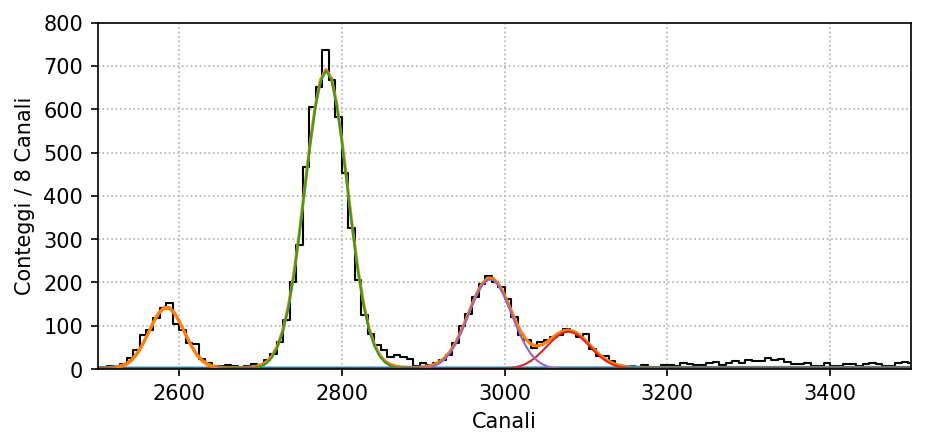

In [106]:
fig, ax = plt.subplots(figsize=(7,3), nrows=1, ncols=1, dpi=150)
ax.grid(ls=":")
# ax.set_yscale('log')

centers = histogram.axes[0].centers
counts = histogram.values()

ax.step(centers, counts, where='mid', c='k', lw=1)

x_i = np.linspace(x[0], x[-1], 1000)
fit_i = model.eval(result.params, x=x_i)

ax.plot(x_i, fit_i, c='C1')

components = result.eval_components(x=x_i)

for key in components.keys():
    ax.plot(x_i, components[key], lw=1)

ax.set_xlim(2.5e3,3.5e3)
ax.set_ylim(0,1.2e3)
ax.set_ylim(0,8e2)
ax.set_xlabel('Canali')
ax.set_ylabel(f'Conteggi / {rebin} Canali')